In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [3]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

## Constants

In [4]:
weight_scale = 1.2 / 100
g = 0.85

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 10.0
delay_std = delay_mean * 0.6
v_ext = 0.10

excitatory_type = "Regular_Spiking"
inhibitory_type = "Fast_Spiking"

## Generate network

In [5]:
G = nx.DiGraph()

# Add 1000 nodes
for i in range(1000):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
# excitatory_nodes = random.sample(range(1000), 800)
for i in range(800):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(800, 1000):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw 100 outgoing edges to random nodes
for i in range(1000):
    targets = random.sample(range(1000), 100)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
        else:
            weight = J_E
        delay = max(0.1, np.random.normal(delay_mean, delay_std))
        G.add_edge(i, target, weight=weight, distance=delay)

## Simulation setup

In [6]:
dt = 0.5

In [7]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [8]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

## Simulation

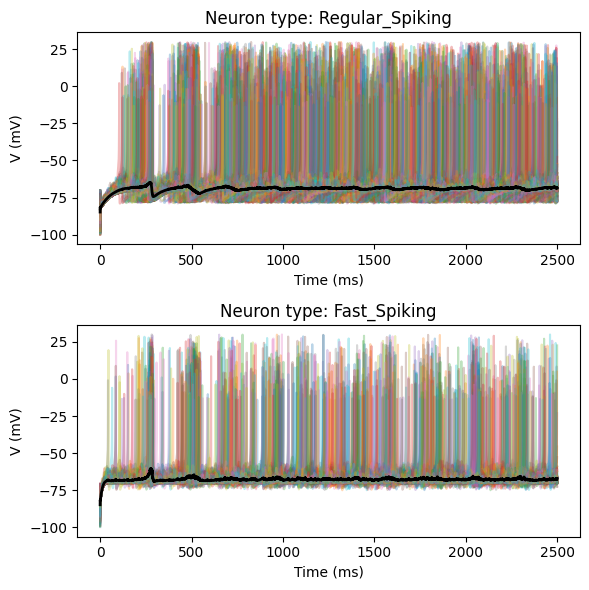

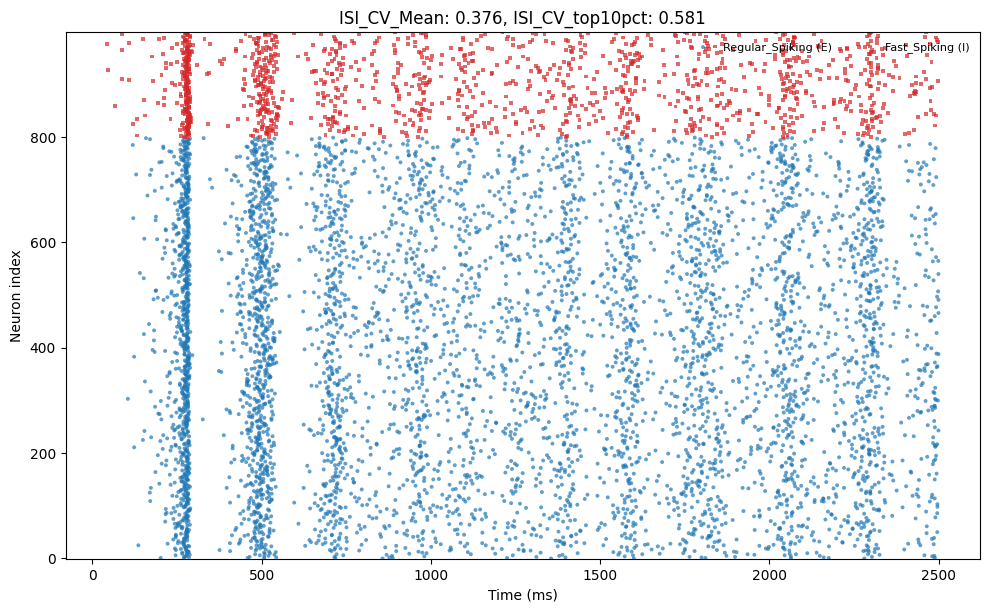

In [9]:

# Randomize initial voltages
Vs = np.random.uniform(-100, -70, size=n_neurons)
us = np.random.uniform(0, 400, size=n_neurons) * 0
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

sim = Simulation(connectome, dt, stepper_type="simple", state0=state0)
# sim = Simulation(connectome, dt, stepper_type="euler_det")

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=0.03)

for i in range(5000):
    sensory_spikes = poisson(dt)
    # I_ext = np.zeros(n_neurons)
    # random_neuron = np.random.randint(0, n_neurons)
    # I_ext[random_neuron] = 2000.0
    sim.step(spike_ext=sensory_spikes)
    # sim.step(I_ext=I_ext)

sim.plot_voltage_per_type(figsize=(6, 6))

import time
time_start = time.time()

# Save sim.stats.Vs, sim.stats.spikes, sim.stats.ts for analysis
np.savez(f"sim_stats_{time_start}.npz", Vs=sim.stats.Vs, spikes=sim.stats.spikes, ts=sim.stats.ts)

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}")

In [14]:
connectome.W

array([[0.021     , 0.021     , 0.021     , ..., 0.021     , 0.021     ,
        0.        ],
       [0.021     , 0.021     , 0.        , ..., 0.021     , 0.00297284,
        0.        ],
       [0.021     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.021     ],
       ...,
       [0.0102    , 0.0102    , 0.0102    , ..., 0.0102    , 0.0102    ,
        0.0102    ],
       [0.0102    , 0.0102    , 0.0102    , ..., 0.0102    , 0.0102    ,
        0.0102    ],
       [0.0102    , 0.0102    , 0.0102    , ..., 0.0102    , 0.0102    ,
        0.0102    ]])

In [11]:
sim.stats.compute_metrics(dt, bin_ms_participation=300)

{'rate_mean_Hz': 2.7330533893221354,
 'rate_median_Hz': 2.7994401119776042,
 'rate_p95_Hz': 3.199360127974405,
 'ISI_CV_median': 0.3657862283559572,
 'ISI_CV_mean': 0.3764733591819369,
 'ISI_CV_mean_E': 0.3660379615278454,
 'ISI_CV_mean_I': 0.4182149497983033,
 'ISI_CV_mean_top10pct': 0.5810823958154273,
 'refractory_violations_per_neuron': 0.0,
 'Fano_median_300ms': 0.2857142857142857,
 'mean_noise_corr_50ms': 0.06012442649069758,
 'participation_frac_mean_300ms': 0.7918749999999999,
 'participation_frac_median_300ms': 0.7315,
 'participation_frac_p95_300ms': 0.9923,
 'participation_frac_total': 1.0,
 'pop_spec_entropy': 5.5711917010711804,
 'pop_psd_freq_hz': array([0.00000000e+00, 3.99920016e-01, 7.99840032e-01, ...,
        9.99000200e+02, 9.99400120e+02, 9.99800040e+02]),
 'pop_psd': array([1.60110145e-26, 1.24609800e+05, 3.55099816e+05, ...,
        2.86230861e+03, 8.44578953e+02, 2.43066022e+02])}

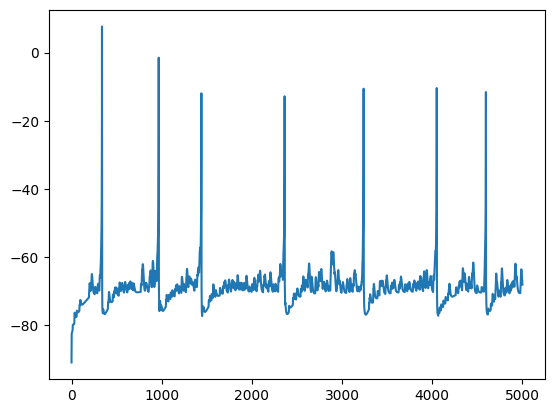

In [12]:
# Plot spikes for one neuron
plt.plot(np.array(sim.stats.Vs)[:,125])

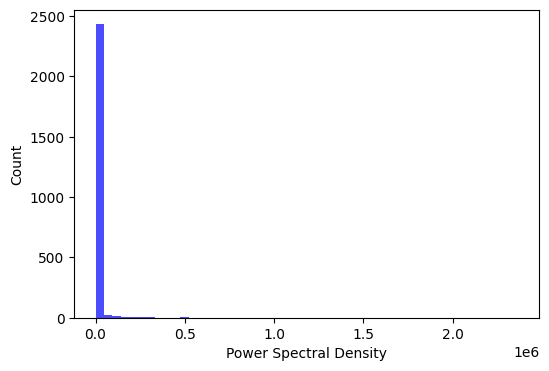

In [13]:
# Histogram of pop_psd
plt.figure(figsize=(6, 4))
plt.hist(sim.stats.compute_metrics(dt)['pop_psd'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Power Spectral Density')
plt.ylabel('Count')
plt.show()

## Grid search